# NLP analysis: zhengzhou Restaruants informations
- Author: Yiran Jing



In [141]:
import requests
import json
from lxml import etree
import pandas as pd
import re
import math
import urllib
import urllib.request as urllib2
import xlsxwriter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from pyquery import PyQuery as pq
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.project import get_project_settings
import csv
import numpy as np

pd.set_option('display.max_columns', 500) # show all columns
pd.set_option('display.max_rows', 500) # show all columns

In [13]:
import jieba # to support chinese
jieba.enable_parallel(4)

In [58]:
# 调整package可以显示中文
import matplotlib
chinesefont = matplotlib.font_manager.FontProperties(fname='../../fonts/HanyiSentyLotus.ttf')

#### Load data

In [14]:
#commentslist
Restaurants  = pd.read_csv("../../../data/ZhengzhouInfos/ZhengZhouRestaurants.csv")
Restaurants.head(20)

,店铺名称,页面id,类别,品牌名称,品牌id,品牌logo,评分,平均价格,最低价格,所属地区,地区Id,纬度,经度,详细地址,楼层,地铁站id,停车信息,优惠套餐情况,营业时间,联系电话,累计售出份数,餐厅简介,特色菜,是否小吃,有无外卖,上周订单数,历史订单数,wifi,支持预定
0,状元烤场(大学路总店),95191,烤肉自助,状元烤场餐厅,791004,http://p1.meituan.net/poi/8c3d908bf32817d01745...,4.3,48,51.90,郑州大学,167,34.745370,113.644607,二七区大学路与中原路交叉口向南100米路东永辉超市2楼,NaN,"1351,",停车位收费标准：玉凤路店提供状元烤场专属免费停车位,单人午/晚餐51.9元，单人晚餐56.9元;,周一至周日 11:00-14:30 17:00-21:30 2019-02-04至2019...,0371-86062929/400-003-1321,653476,状元烤场处处充满着时尚优雅的环境，让食客进去就能感受到一种时尚的气息，这里经营多种菜品，以韩...,NaN,False,0,858,653476,True,False
1,方燕烤猪蹄(安微名吃二七广场一店),4571500,猪脚,方燕烤猪蹄,1688264,http://p1.meituan.net/poi/7a13124be638e4eccc9a...,5.0,10,10.90,火车站/二七广场,167,34.749738,113.664692,二七区裕元里百年德化步行街六道巷北门门口1楼,1,"1353,1352,",NaN,10.9元烤猪蹄，21.8元2人餐;10.9代12元;,周一至周日 10:00-23:00,19939500377,459751,方燕烤猪蹄**秘制配方，精选48余种名贵中草药、**酱料调制而成。无需腌制，调味简单。 文火...,NaN,False,1,404,459751,False,False
2,欧啦自助火锅,12988,火锅自助,欧啦自助火锅,674422,http://p0.meituan.net/poi/e16e32b7b4988be1e20a...,3.8,34,56.90,天旺广场,166,34.799615,113.632852,金水区南阳路与东风路交叉口向北300米路西（依之妮店楼上）,NaN,NaN,免费提供3个停车位,单人午/晚餐56.9元;56.9代69元;,周一至周日 10:00-24:00,0371-63671166,336297,欧啦自助火锅装饰风格简约明了，鹅黄色的光线柔和折射在餐桌上。菜品都采用回转方式，100余中菜...,NaN,False,0,1744,336297,True,False
3,鑫海汇海鲜烤肉自助(二七广场店),41938892,海鲜自助,鑫海汇海鲜烤肉自助,1867219,NaN,5.0,53,49.90,火车站/二七广场,167,34.754328,113.664166,二七区民主路3号华联商厦5层,5,"1353,1354,",NaN,单人午/晚餐51.9元，单人午/晚餐52.9元，单人午/晚餐62.9元，单人午餐62.9元，...,周一至周日 09:00-22:00,0371-85966331/85966332,314307,NaN,NaN,False,0,1844,314307,True,False
4,方燕烤猪蹄(安微名吃二七广场二店),5029746,猪脚,方燕烤猪蹄,1688264,http://p1.meituan.net/poi/7a13124be638e4eccc9a...,5.0,10,10.90,火车站/二七广场,167,34.750238,113.664539,二七区兴盛路六道巷内61号傣妹火锅楼下,1,"1353,1352,",NaN,10.9元烤猪蹄，21.8元2人餐;10.9代12元;,周一至周日 10:00-23:00,15639902995,305112,方燕烤猪蹄**秘制配方，精选48余种名贵中草药、**酱料调制而成。无需腌制，调味简单。 文火...,NaN,False,0,153,305112,False,False
5,汉釜宫海鲜自助烧烤涮(曼哈顿店),2185893,综合自助,NaN,0,NaN,3.7,50,1.00,曼哈顿广场,166,34.760494,113.709024,金水区金水路与未来路交叉口曼哈顿广场奥斯卡电影院东南侧斜对面二楼,NaN,"1356,1357,",停车位收费标准：本店斜对面地下停车场和小区院内地下停车场有对外开放停车位,单人午/晚餐1元，单人午/晚餐52.9元，单人午餐55.9元，单人午/晚餐59.9元;,周一至周日 11:00-14:00 17:30-21:30 2019-02-03至2019...,0371-53788868/18224523239,294949,北京汉釜宫韩式自助烤肉以经营发展韩式宫廷美食而闻名东南亚，其特色的韩式烧烤餐饮更是受到海内外...,NaN,False,0,324,294949,True,False
6,釜山第一烤场烧烤涮自助餐厅(二七万达店),6309483,综合自助,釜山第一烤场,1648804,http://p1.meituan.net/poi/e311ed01e20093b8bfb7...,3.6,44,2.00,二七万达,167,34.717710,113.642278,二七区航海路与大学路交叉口二七万达金街132号（3号门出口）,1,NaN,NaN,单人午/晚餐2元，单人午餐29.9元，单人午餐46.9元，单人午/晚餐51.9元，双人午餐9...,周一至周日 11:30-14:30 17:30-22:00,0371-61770302,287961,北京汉丽轩烤肉超市，提供韩式自助烤肉服务，颠覆传统韩式烧烤和自助餐的运营模式，提出了“烤肉超...,NaN,False,0,1098,287961,True,False
7,诸葛烤串(百年德化店),42734449,烤串,NaN,0,NaN,4.4,10,19.80,火车站/二七广场,167,34.750851,113.666437,二七区彩虹路德化新街负一楼5号口,1,"1353,1352,",NaN,19.8元烤面筋8串;,周一至周五 10:00-22:00,13283871958,262301,NaN,NaN,False,0,0,262301,False,False
8,喜虾客(无限城店),72091213,虾蟹火锅,NaN,0,NaN,4.8,39,59.90,火车站/二七广场,167,34.749190,113.666309,二七区德化街无限城4楼,4,"1353,1352,",NaN,每满100减11（买单立享）;双人餐59.9元起，2-3人餐82元，3-4人餐98元，6人餐...,周一至周日 10:00-22:00 2019-02-04至2019-02-09 休息,0371-60205952,252234,NaN,NaN,False,0,2024,252234,True,False
9,锅大侠火锅(德化步行街店),2183814,四川火锅,锅大侠火锅,1097547,http://p1.meituan.net/poi/0b5890a3fb68c495cf7b...,4.7,39,82.00,火车站/二七广场,167,34.753753,113.666512,二七区德化步行街100号天成银楼三楼四楼（近火车站）,NaN,"1353,1354,",停车位收费标准：电讯商家,双人餐82元，2-3人餐89元，4-5人餐168元，6-8人餐243元，8-10人餐319元...,周一至周日 10:00-01:00 2019-02-04至2019-02-07 休息,0371-66960999,239668,锅大侠餐饮连锁成立于2009年，是一家以经营火锅为主题的休闲式连锁餐厅。公司自2009年创办...,NaN,False,0,41,239668,True,False


## 1. 郑州人饮食喜好研究
find most popular food categories(top 30 ) in Zhengzhou 

In [15]:
len(Restaurants['类别'].unique())

108

- we have 108 categories in Zhengzhou 
- 郑州美团饭店有108个类别

In [16]:
## selct top 30 popular category
top_30_cat = Restaurants['类别'].value_counts()

In [17]:
# convert Series to dataframe
top_30_cat = top_30_cat.to_frame()
top_30_cat = top_30_cat.rename(columns={"类别": "累计数量"})
top_30_cat['类别'] = top_30_cat.index



In [18]:
file = open("../../../data/ZhengzhouInfos/category.txt","w")
for index,row in top_30_cat.iterrows():
    for i in range(row['累计数量']): 
        file.write(row['类别'])
        file.write(" ")
file.close() 

text = open('../../../data/ZhengzhouInfos/category.txt', 'r',encoding= 'UTF-8-sig').read()

In [22]:
from PIL import Image

backgroud=np.array(Image.open("../../fonts/xy.jpg")) #背景图片

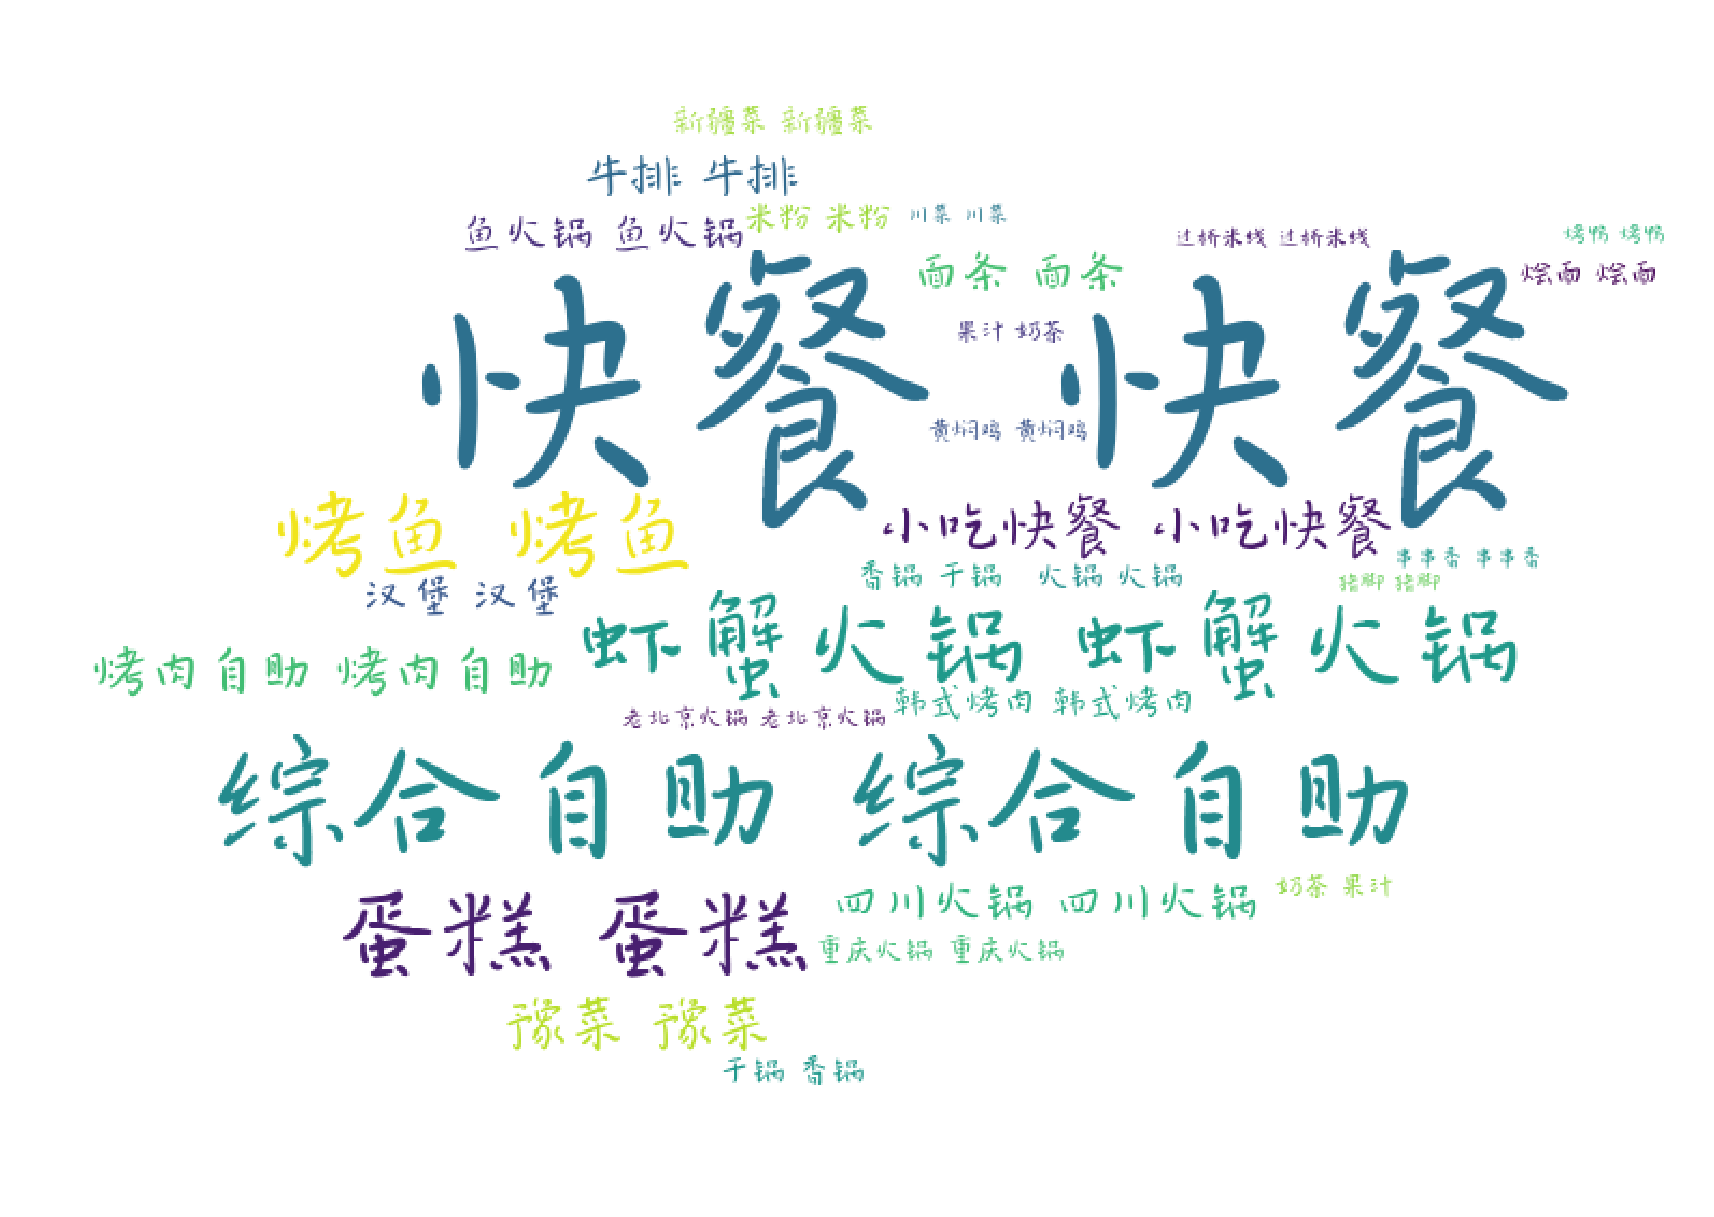

In [26]:
import jieba
from scipy.misc import imread

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple([255,255,255]) # RGB code of white color

from wordcloud import ImageColorGenerator



# indicate the font path that can display Chinese
font_filename = '../../fonts/HanyiSentyLotus.ttf'

from wordcloud import WordCloud
import matplotlib.pyplot as plt

mywordcloud = WordCloud(font_path=font_filename, background_color="white",
               #background_color="#FFFF99", #背景颜色
               random_state=50,#随机角度
               max_words=30,  #最大词语数量
               mask = backgroud,#写字用的背景图，从背景图取颜色
               max_font_size=200).generate(text) #生成词云

image_color=ImageColorGenerator(backgroud) #生成词云的颜色
plt.rcParams["figure.figsize"] = (30,30) # 调整图片尺寸
plt.imshow(mywordcloud) #显示词云
plt.axis("off") #关闭保存
plt.show()

郑州美团一共有108个美食分类。这个图画了前三十。字体越大说明相关饭店在郑州数量越多。

从这个图可以看出郑州市人民喜欢
1. 快餐小吃类
2. 火锅烧烤类
3. 蛋糕甜品类 (包括果汁奶茶)
4. 面食类（包括米线，米粉，面条，烩面）
5. 自助类

张爷爷空心面属于快餐类和面食类。芙蕾小姐属于甜品蛋糕类，在郑州市场都很受欢迎

## 2. 价格和上周订单数的关系

In [199]:
weeksale_price = Restaurants.groupby('平均价格')['上周订单数'].mean()
weeksale_price = weeksale_price.to_frame()
weeksale_price['价格区间'] = pd.cut(weeksale_price.index, [min(Restaurants['平均价格']), 10, 20, 35,
                                                       50, 65, 80, max(Restaurants['平均价格'])])

In [200]:
weeksale_price = weeksale_price.groupby('价格区间')['上周订单数'].mean()

In [201]:
weeksale_price = weeksale_price.to_frame()
weeksale_price['价格区间'] = weeksale_price.index

In [125]:
weeksale_price

,上周订单数,价格区间
价格区间,,
"(0, 10]",85.944558,"(0, 10]"
"(10, 20]",100.733970,"(10, 20]"
"(20, 35]",96.396848,"(20, 35]"
"(35, 50]",181.459465,"(35, 50]"
"(50, 65]",259.478272,"(50, 65]"
"(65, 80]",266.308944,"(65, 80]"
"(80, 381]",190.650505,"(80, 381]"


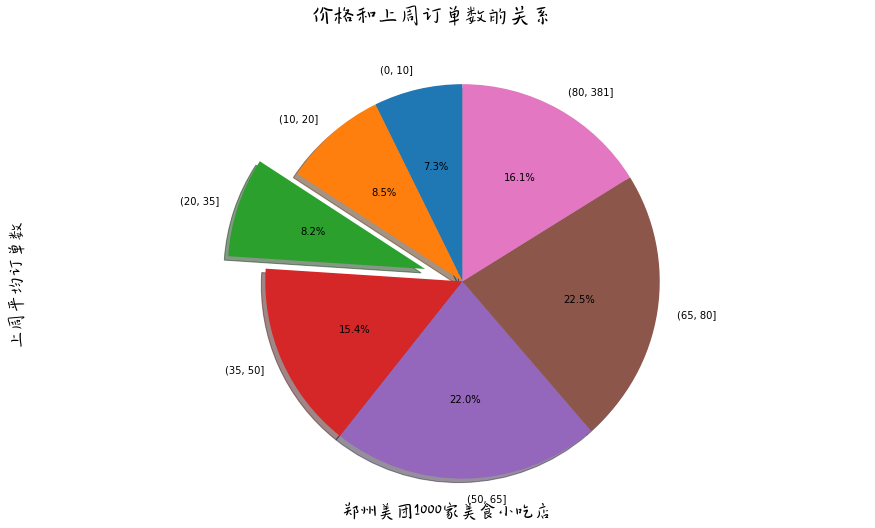

In [119]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = weeksale_price['价格区间']
sizes = weeksale_price['上周订单数']
explode = (0, 0, 0.2 , 0,0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig1.suptitle(u'价格和上周订单数的关系', fontproperties=chinesefont, fontsize=30) 
plt.ylabel(u'上周平均订单数',fontproperties=chinesefont,fontsize=25)  
plt.xlabel(u'郑州美团1000家美食小吃店',fontproperties=chinesefont,fontsize=25)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

从上图可以看出，
1. 当人均价格高于35元时，顾客更倾向于用美团消费价格 （更多的折扣）（平均每家店铺有接近或大于200单）
2. 当人均消费在20-35元时，顾客并没有特别倾向于美团消费 （本来价格就亲民，顾客不太在意通过美团享受折扣）（平均每家店铺低于100单）

结论：
因为张爷爷空心面是价格在20-35元之间的快餐，所以美团优惠未必在吸引顾客方面有特别明显的作用。

推测：
对于30元一下的快餐食品类，顾客更在意味道品质，而不是几块钱价格的优惠。

## 3. 所属地区的平均价格
张爷爷空心面位于
看看这个地方和周围区域的平均消费
作图用的csv

In [156]:
area_price = Restaurants.groupby('所属地区')['平均价格'].mean()

In [157]:
area_price = area_price.to_frame()
area_price['所属地区'] = area_price.index
area_price[['所属地区','平均价格']].to_csv('../../../data/ZhengzhouInfos/area_price.csv', index = False, encoding= 'UTF-8-sig')

## 4. 平均价格和评分的关系

In [53]:
price_rate = Restaurants.groupby('评分')['平均价格'].mean()
price_rate = price_rate.to_frame()
price_rate['评分']= price_rate.index

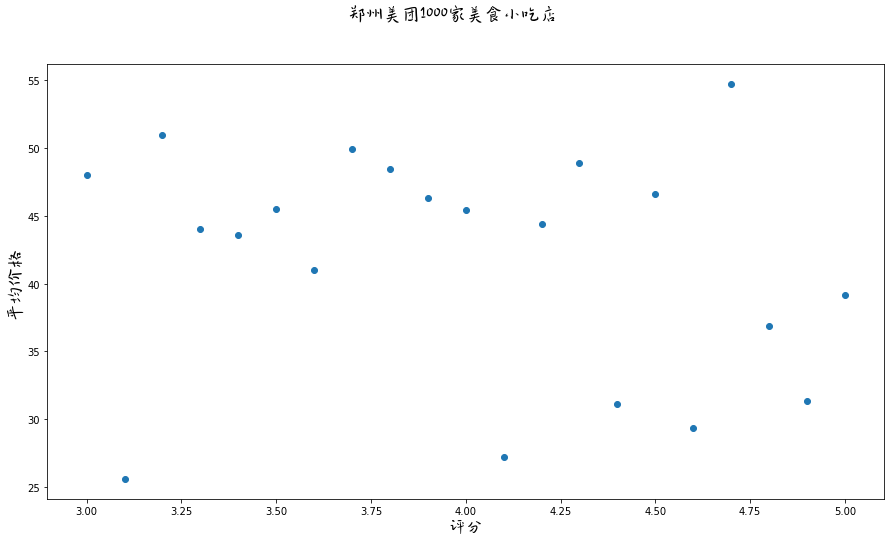

In [77]:
fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,8)
plt.scatter(price_rate['评分'], price_rate['平均价格'])
fig.suptitle(u'郑州美团1000家美食小吃店', fontproperties=chinesefont, fontsize=25)
plt.xlabel(u'评分',fontproperties=chinesefont,fontsize=25)  
plt.ylabel(u'平均价格',fontproperties=chinesefont,fontsize=25) 
plt.show()   

从上图可以看出：
1. 价格在20元到30元之间的小吃店基本都评分较高（4分以上）
2. 顾客对高价格的食物评分更加严苛：价格超过40元较难获得好的评价

结论
20-30元的价格定位比较符合郑州人的消费心理。所以张爷爷空心面在郑州地区有价格优势，

## 5. 郑州面馆小吃店的研究
筛选出带有‘面’‘米线’和‘粉’的饭店进行分析

In [160]:
noodle_cat = []
for index, row in Restaurants.iterrows():
    if "面" in row["类别"] or '粉' in row["类别"] or '米线' in row["类别"]:
        if row["类别"] not in noodle_cat:
            noodle_cat.append(row["类别"])
            
noodle_cat

['米粉', '面条', '烩面', '过桥米线', '粉丝汤', '螺蛳粉', '土豆粉', '热干面', '凉皮/凉粉', '炸酱面', '肥肠粉']

In [176]:
Noodle_Restaurants_1 = Restaurants[Restaurants["类别"] == '米粉']
Noodle_Restaurants_2 = Restaurants[Restaurants["类别"] == '面条']
Noodle_Restaurants_3 = Restaurants[Restaurants["类别"] == '烩面']
Noodle_Restaurants_4 = Restaurants[Restaurants["类别"] == '过桥米线']
Noodle_Restaurants_5 = Restaurants[Restaurants["类别"] == '粉丝汤']
Noodle_Restaurants_6 = Restaurants[Restaurants["类别"] == '螺蛳粉']
Noodle_Restaurants_7 = Restaurants[Restaurants["类别"] == '土豆粉']
Noodle_Restaurants_8 = Restaurants[Restaurants["类别"] == '凉皮/凉粉']
Noodle_Restaurants_9 = Restaurants[Restaurants["类别"] == '炸酱面']
Noodle_Restaurants_10 = Restaurants[Restaurants["类别"] == '肥肠粉']

Noodle_Restaurants = pd.concat([Noodle_Restaurants_1, Noodle_Restaurants_2,Noodle_Restaurants_3,
                               Noodle_Restaurants_4, Noodle_Restaurants_5, Noodle_Restaurants_6, 
                               Noodle_Restaurants_7, Noodle_Restaurants_8, Noodle_Restaurants_9,
                               Noodle_Restaurants_10]).reset_index(drop=True)



#Noodle_Restaurants.head()

### 郑州面馆小吃店的美团均分情况，人均消费情况和上周订单数

In [190]:
Noodle_rate = Noodle_Restaurants.groupby('类别')['评分'].mean()
Noodle_rate = Noodle_rate.to_frame()
Noodle_rate['类别'] =Noodle_rate.index

In [191]:
Noodle_price = Noodle_Restaurants.groupby('类别')['平均价格'].mean()
Noodle_price = Noodle_price.to_frame()

In [192]:
Noodle_count = Noodle_Restaurants.groupby('类别')['上周订单数'].mean()
Noodle_count = Noodle_count.to_frame()

In [193]:
Noodle_rate['平均价格'] = Noodle_price['平均价格']
Noodle_rate['上周订单数'] = Noodle_count['上周订单数']

In [194]:
Noodle_rate

,评分,类别,平均价格,上周订单数
类别,,,,
凉皮/凉粉,4.200000,凉皮/凉粉,11.500000,18.000000
土豆粉,4.114286,土豆粉,15.285714,91.857143
炸酱面,4.100000,炸酱面,9.000000,6.000000
烩面,4.285714,烩面,20.190476,86.857143
米粉,4.787500,米粉,11.666667,136.875000
粉丝汤,4.425000,粉丝汤,11.750000,107.750000
肥肠粉,5.000000,肥肠粉,10.000000,76.000000
螺蛳粉,4.942857,螺蛳粉,14.571429,130.428571
过桥米线,4.183333,过桥米线,19.083333,121.666667


In [195]:
Noodle_rate[['类别','评分','平均价格','上周订单数']].to_csv('../../../data/ZhengzhouInfos/noodle_info.csv', index = False, encoding= 'UTF-8-sig')



## 6. Wifi的重要性 （和评分，平均消费是否有关）
有wifi服务会让价格有所提升，但是对评分并无明显影响。而且没有wifi的店铺订单数还更多

In [196]:
wifi = Restaurants.groupby('wifi')['评分'].mean()
wifi

wifi
False    4.533218
True     4.417609
Name: 评分, dtype: float64

In [197]:
wifi = Restaurants.groupby('wifi')['平均价格'].mean()
wifi

wifi
False    39.273356
True     41.263043
Name: 平均价格, dtype: float64

In [198]:
wifi = Restaurants.groupby('wifi')['上周订单数'].mean()
wifi

wifi
False    203.906574
True     153.977174
Name: 上周订单数, dtype: float64